In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def create_gaussian_kernel():
    """
    Create the Gaussian kernel h = [1 4 6 4 1]/16 
    """
    return np.array([1, 4, 6, 4, 1]) / 16.0


def gaussian_filter(img, kernel):
    """
    Apply separable Gaussian filtering
    """
    # Handle both grayscale and color images
    if len(img.shape) == 3:
        filtered = np.zeros_like(img, dtype=np.float32)
        for i in range(3):
            filtered[:, :, i] = cv2.sepFilter2D(img[:, :, i].astype(np.float32), -1,
                                                kernel, kernel)
        return filtered
    return cv2.sepFilter2D(img.astype(np.float32), -1, kernel, kernel)


def generate_gaussian_pyramid(img, levels):
    """
    Generate Gaussian pyramid with L+1 levels as per equation (1) in PDF
    """
    pyramid = [img.astype(np.float32)]
    kernel = create_gaussian_kernel()

    for i in range(levels):
        filtered = gaussian_filter(pyramid[-1], kernel)
        # Downsample by factor of 2
        downsampled = filtered[::2, ::2]
        pyramid.append(downsampled)

    return pyramid


def generate_laplacian_pyramid(img, levels):
    """
    Generate Laplacian pyramid with L+1 levels as per equation (2) in PDF
    """
    gaussian_pyr = generate_gaussian_pyramid(img, levels)
    pyramid = []

    for i in range(levels):
        size = (gaussian_pyr[i].shape[1], gaussian_pyr[i].shape[0])
        expanded = cv2.resize(gaussian_pyr[i + 1], size)
        laplacian = gaussian_pyr[i] - expanded
        pyramid.append(laplacian)

    # Add the smallest Gaussian level at the end
    pyramid.append(gaussian_pyr[-1])

    return pyramid


def create_masks(image_shape, regions):
    """
    Create masks following properties 1 and 2:
    1. Sum of all masks = 1 everywhere
    2. mk(n) = 1 where image k should be visible
    """
    masks = {}
    total_mask = np.zeros(image_shape[:2], dtype=np.float32)

    for name, region in regions.items():
        mask = np.zeros(image_shape[:2], dtype=np.float32)
        y1, y2, x1, x2 = region
        mask[y1:y2, x1:x2] = 1
        # Apply Gaussian blur for smooth transitions
        mask = cv2.GaussianBlur(mask, (31, 31), 10)
        masks[name] = mask
        total_mask += mask

    # Normalize masks to ensure they sum to 1 (Property 1)
    total_mask = np.maximum(total_mask, 1e-7)
    for name in masks:
        masks[name] = masks[name] / total_mask

    return masks


def blend_pyramids(pyramid1, pyramid2, mask_pyramid):
    """
    Blend pyramids according to equation (4)
    """
    blended = []
    for i in range(len(pyramid1)):
        p1 = pyramid1[i]
        p2 = pyramid2[i]
        mask = mask_pyramid[i]

        if len(p1.shape) == 3:
            mask = np.expand_dims(mask, axis=2)

        blend = mask * p1 + (1 - mask) * p2
        blended.append(blend)

    return blended


def reconstruct_from_pyramid(pyramid):
    """
    Reconstruct the final image from a pyramid
    """
    current = pyramid[-1]

    for level in reversed(pyramid[:-1]):
        size = (level.shape[1], level.shape[0])
        expanded = cv2.resize(current, size)
        current = expanded + level

    return current

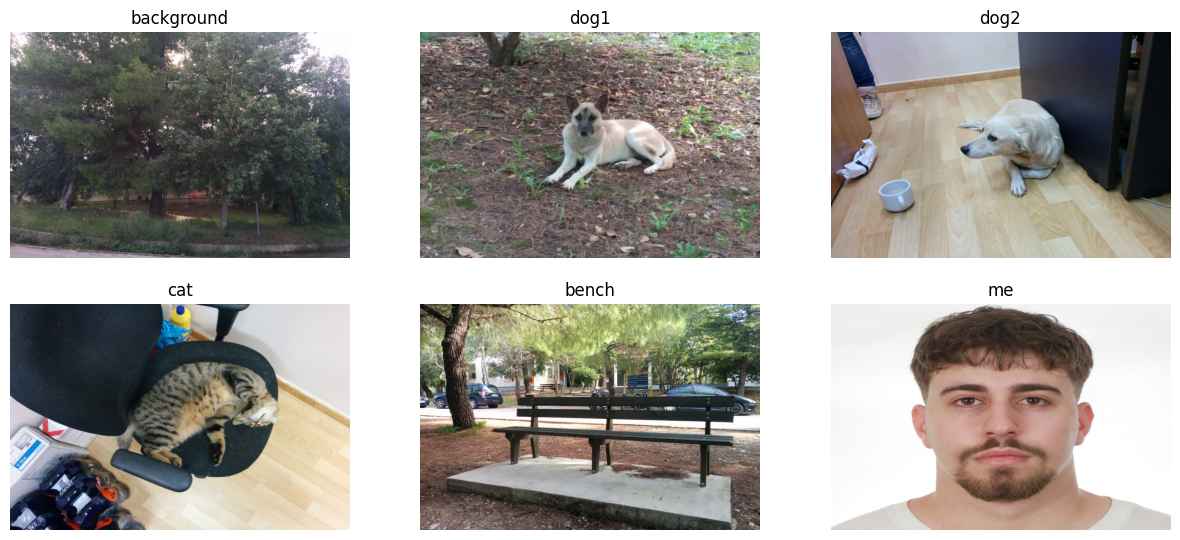

In [3]:
# Load images and resize to same dimensions
target_size = (800, 1200)  # Height, Width
image_paths = {
        'background': 'photos/P200.jpg',
        'dog1': 'photos/dog1.jpg',
        'dog2': 'photos/dog2.jpg',
        'cat': 'photos/cat.jpg',
        'bench': 'photos/bench.jpg',
        'me': 'photos/nick.png' 
    }

# Load and resize images
images = {}
for name, path in image_paths.items():
    img = cv2.imread(path)
    if img is None:
        print(f"Failed to load {path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]))
    images[name] = img.astype(np.float32) / 255.0

# Define regions for each image (y1, y2, x1, x2)
regions = {
    'dog1': (250, 550, 150, 450),
    'dog2': (150, 450, 550, 850),
    'cat': (350, 650, 750, 1050),
    'bench': (450, 750, 250, 550),
    'me': (150, 450, 350, 650)
}

# Number of pyramid levels
L = 6

# Create masks
masks = create_masks(target_size + (3,), regions)

# Initialize result with background
result = images['background'].copy()

# Process each image
for name, img in images.items():
    if name == 'background':
        continue

    # Generate pyramids
    mask_gaussian = generate_gaussian_pyramid(masks[name], L)
    img_laplacian = generate_laplacian_pyramid(img, L)
    result_laplacian = generate_laplacian_pyramid(result, L)

    # Blend pyramids
    blended = blend_pyramids(img_laplacian, result_laplacian, mask_gaussian)

    # Reconstruct and update result
    result = reconstruct_from_pyramid(blended)
    result = np.clip(result, 0, 1)

# Display results
plt.figure(figsize=(15, 10))

# Show original images
for i, (name, img) in enumerate(images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')


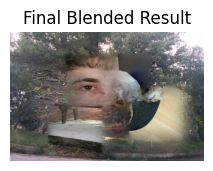

In [4]:
# Show final result
plt.subplot(3, 3, 7)
plt.imshow(result)
plt.title('Final Blended Result')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save result
plt.imsave('photos/blended_composition.png', result)
